In [53]:
from gurobipy import *
import math
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from shapely.geometry import Polygon
from statsmodels.stats.weightstats import DescrStatsW

In [54]:
gdf_open_street2019 = gpd.read_file('./gdf_open_street2019/gdf_open_street2019_Ourem.shp')
# gdf_open_street2019 = gdf_open_street2019.to_crs({'init': 'epsg:4326'})

motorway = ['motorway', 'motorway_link']
primary = ['primary', 'trunk', 'secondary']
n_mapear = ['cycleway', 'steps', 'track','track_grade1','track_grade2','track_grade3','track_grade4',
            'track_grade5','pedestrian','footway', 'unclassified','path']

dict_temp = {}
for nome in gdf_open_street2019.fclass.unique(): 
    if nome in motorway:
        dict_temp [nome] = list((0.4,6))
    elif nome in primary: 
        dict_temp [nome] = list((0.3,4))
    elif nome in n_mapear:
        dict_temp [nome] = list((0.2,1))
    else: 
        dict_temp [nome] = list((0.3,2))

In [55]:
gdf_COS_2015=gpd.read_file ('./gdf_COS_Ourém/gdf_COS_Ourém.shp')
# gdf_COS_2015=gdf_COS_2015.to_crs({'init': 'epsg:4326'})
#recebe RGB em dicionários de float e devolve o hexadecimal correspondente
def rgb_to_hex (diccionario_cores): 
    dict_novo = {}
    for nome in diccionario_cores:
        dict_novo [nome] = '#%02x%02x%02x'%tuple(int(i * 255) for i in diccionario_cores[nome])
    return(dict_novo)
#define RGB para cada tipo de ocupação de solo 
colors_cos = {'Territórios artificializados': (0.8, 0, 0), 'Agricultura': (0.9, 0.7, 0.03), 'Pastagens': (0.96, 0.93, 0.03),
              'Sistemas agro-florestais': (0.85, 0.6, 0),'Florestas': (0, 0.5, 0), 'Matos': (0, 0.7, 0),
              'Espaços descobertos ou com vegetação esparsa': (0.9, 0.9, 0.5),'Zonas húmidas': (0.9, 0.9, 0.5), 
              'Corpos de água': (0.3, 0.6, 1)}
colors_cos_hexa = rgb_to_hex(colors_cos)

In [56]:
#carrega alunos das subsecções de Ourém e matriz de distâncias
df_alunos_subseccao = pd.read_csv('./df_alunos_subseccao_2020.csv', dtype={'Unnamed: 0':str})
df_alunos_subseccao.index= df_alunos_subseccao['Unnamed: 0']
distanceMatrix = pd.read_csv('./00_Base_de_dados/Distancias/distance_matrix_schools_ourem.csv', dtype={'to':str, 'origin':str})
distanceMatrix['Freg_origin'] = distanceMatrix.loc[:,'origin'].astype(str).str[0:6]
distanceMatrix['Freg_destino'] = distanceMatrix.loc[:,'to'].astype(str).str[0:6]
# df['new_col'] = df['First'].astype(str).str[0]

In [80]:
# Load School Data
schools = gpd.read_file('../../01_Analise_espacial_escolas/Escolas_Ourem/gdf_escolas_Ourem2019_capacidades.shp')
# schools = schools.to_crs({'init': 'epsg:4326'})
schools['FID_x'] = schools.index.astype(str)

In [58]:
#carrega os CAOP das freguesias e municípios e adiciona centroides
gdf_BGRI_2011_Ourem = gpd.read_file('./00_Base_de_dados/BGRI_2011/gdf_BGRI_2011_Ourem.shp')
gdf_BGRI_2011_Ourem.index = gdf_BGRI_2011_Ourem.BGRI11
gdf_BGRI_2011_Ourem['centroid']= gdf_BGRI_2011_Ourem.centroid
# gdf_BGRI_2011_Ourem[gdf_BGRI_2011_Ourem.FR11=='04'].centroid.plot()
gdf_freguesia_CAOP2018 = gpd.read_file ('./gdf_Freguesias_CAOP2018_Ourém/gdf_Freguesias_CAOP2018_Ourém.shp')
# gdf_BGRI_2011_Ourem = gdf_BGRI_2011_Ourem.to_crs({'init': 'epsg:4326'})
# gdf_freguesia_CAOP2018 = gdf_freguesia_CAOP2018.to_crs({'init': 'epsg:4326'})

In [59]:
#transforma distâncias em custos
distanceMatrix['custo'] = distanceMatrix.real_distance*2*0.36*180*10/1000
#elimina subsecções sem alunos (não podem ser os residuais porque alguns têm alunos)
c_alunos = df_alunos_subseccao[df_alunos_subseccao['1_CEB_Proj_2020']>0].index
distanceMatrix_sres = distanceMatrix[(distanceMatrix.to.isin(c_alunos))&(distanceMatrix.Capacida_1>0)]
Matriz_reduzida = distanceMatrix_sres

In [60]:
alunos_por_subs  = pd.DataFrame(index=Matriz_reduzida.to.unique())
alunos_por_subs = alunos_por_subs.join(df_alunos_subseccao['1_CEB_Proj_2020'])
alunos_por_subs['1_CEB_Proj_2020'] = alunos_por_subs['1_CEB_Proj_2020'].fillna(0)
tuple_alunos_por_subs = dict(zip(alunos_por_subs.index, alunos_por_subs['1_CEB_Proj_2020']))
localizacoes = Matriz_reduzida.origin.unique()
alunos_por_subs.sum()

1_CEB_Proj_2020    1345.02368
dtype: float64

In [61]:
escolas1CEB = schools[schools.Capacida_1>0]
capacidades=dict(zip(escolas1CEB.index.astype(str), escolas1CEB.Capacida_1))

# fig, ax = plt.subplots(figsize=(10, 10))
# escolas1CEB.plot(ax=ax, zorder =1000, color='black')
# gdf_BGRI_2011_Ourem.plot(ax=ax, zorder=1)

In [62]:
lista = list(zip(Matriz_reduzida.to, Matriz_reduzida.origin, Matriz_reduzida.custo))
d_custos_dist = {}
for i, k, l  in lista: 
    d_custos_dist[i,k] = l

l_orig_dest_capacid = []
l_tuplas  = list(zip(Matriz_reduzida.to, Matriz_reduzida.origin))

for i,j in l_tuplas:
    l_orig_dest_capacid.append((i,j))
    
l = list(zip(Matriz_reduzida.to, Matriz_reduzida.origin, Matriz_reduzida.real_distance))
d_dist = {}
for i,j,k in l:
    d_dist[i,j] = k

In [76]:
m = Model('escolas')
m.reset()

Discarded solution information


In [64]:
#variável de decisão do custo das distâncias para escolas
x = {}
x = m.addVars(l_orig_dest_capacid, obj=d_custos_dist)
m.update()
#restrição que garante que todos os alunos são alocados
for i in tuple_alunos_por_subs.keys():
    m.addConstr(quicksum(x[i,j] for j in localizacoes) == tuple_alunos_por_subs[i], f'alunos_alocados_{i}_{j}')

#restrição que garante que a alocação respeita as capacidade
for j in localizacoes:
   m.addConstr(quicksum(x[i,j] for i in tuple_alunos_por_subs.keys()) <= capacidades [j], f'capacidade_{capacidades [j]}_escola_{j}')

m.setObjective(quicksum(x[i,j] for i,j in x), GRB.MINIMIZE)
# m.setParam('TimeLimit', 5*60)
# m.setParam(GRB.Param.Method, 3)
m.update()
m.optimize()

Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (win64)
Optimize a model with 947 rows, 21252 columns and 42504 nonzeros
Model fingerprint: 0x3cf7b3f8
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve time: 0.05s
Presolved: 947 rows, 21252 columns, 42504 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.320e+02
 Factor NZ  : 9.280e+02
 Factor Ops : 1.344e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.63587314e+04  1.34502368e+03  1.78e+02 0.00e+00  3.49e-01     0s
   1   4.23262630e+03  1.33912637e+03  1.40e+01 3.25e-14  3.84e-02     0s
   2   1.34502368e+03  1.34284904e+03  6.66e-16 3.19e-14  4.99e-03     0s
   3   1.34502368e+03  

In [70]:
m = Model('escolas')
m.reset()

#variável de decisão do custo das distâncias para escolas
x = {}
x = m.addVars(l_orig_dest_capacid, lb=0.0, vtype='C', name='urso')

#restrição que garante que todos os alunos são alocados
for i in tuple_alunos_por_subs.keys():
    m.addConstr(quicksum(x[i,j] for j in localizacoes) == tuple_alunos_por_subs[i], f'alunos_alocados_{i}_{j}')

#restrição que garante que a alocação respeita as capacidade
for j in localizacoes:
   m.addConstr(quicksum(x[i,j] for i in tuple_alunos_por_subs.keys()) <= capacidades [j], f'capacidade_{capacidades [j]}_escola_{j}')

m.setObjective(quicksum(x[i,j]*d_custos_dist[i,j] for i,j in x), GRB.MINIMIZE)
# m.setParam('TimeLimit', 5*60)
# m.setParam(GRB.Param.Method, 3)
m.update()
m.optimize()

Discarded solution information
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (win64)
Optimize a model with 947 rows, 21252 columns and 42504 nonzeros
Model fingerprint: 0xdedcd329
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+01, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve time: 0.05s
Presolved: 947 rows, 21252 columns, 42504 nonzeros

Ordering time: 0.00s

Barrier performed 0 iterations in 0.06 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 39 iterations and 0.06 seconds
Optimal objective  3.101251232e+06


In [71]:
d={}
for i in x: 
    if x[i].X > 0e-4:
        d[i]= x[i].X
sum(d.values())

1345.0236800000043

In [72]:
alunos_alocados = {}
for (i,j) in d:
    if x[(i,j)].X > 0.001:
        alunos_alocados [i,j] = i, j, d[i,j], d_dist[i,j]
        
df_alunos_alocados = pd.DataFrame.from_dict(alunos_alocados, orient='index', columns=[ 'SubSection', 'School', 'alunos_aloc', 'distancia',])
# df_alunos_alocados.sum(axis=0)
df_alunos_alocados['prod_dist_alun'] = df_alunos_alocados.alunos_aloc*df_alunos_alocados.distancia
# df_alunos_alocados.prod_dist_alun.sum()/df_alunos_alocados.alunos_aloc.sum()

In [73]:
escolas_localizadas = df_alunos_alocados.groupby('School').sum()
escolas_localizadas = pd.merge(escolas_localizadas, schools, left_on='School', right_on='FID_x')
escolas_localizadas.index =  escolas_localizadas['FID_x'].astype(str)

In [74]:
#Cria as linhas dos alunos alocadas  para serem plotadas 
d_linhas={}
d_lic={}

for procura, escolas in df_alunos_alocados.index: 
    d_linhas[procura, escolas] = float(df_alunos_alocados.loc[[(procura,escolas)],'alunos_aloc'])
    d_lic[procura, escolas] = LineString([gdf_BGRI_2011_Ourem.loc[procura,:].centroid, escolas_localizadas.loc[escolas,:].geometry])

gdg_linhas = gpd.GeoDataFrame(index= d_lic.keys())
gdg_linhas.geometry=list(d_lic.values())
gdg_linhas['linhas'] = list(d_linhas.values())

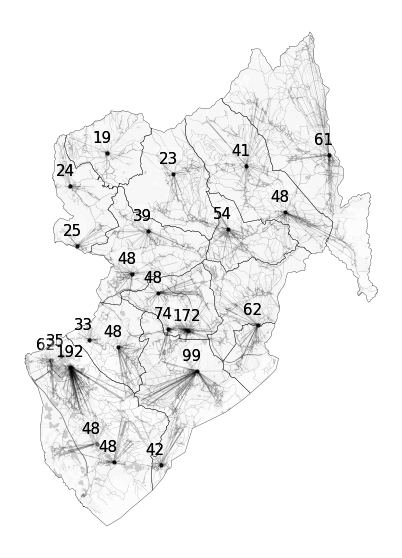

In [75]:
colors_cos = {'Territórios artificializados': (0, 0, 0), 'Agricultura': (0.75, 0.75, 0.75), 
              'Pastagens': (0.9, 0.9, 0.9), 'Sistemas agro-florestais': (0.85, 0.85, 0.85),
              'Florestas': (0.85, 0.85, 0.85),  'Matos': (0.95, 0.95, 0.95),
              'Espaços descobertos ou com vegetação esparsa': (1, 1, 1),
              'Zonas húmidas': (1, 1, 1), 'Corpos de água': (0.3, 0.3, 0.3)}
colors_cos_hexa = rgb_to_hex(colors_cos)

fig, ax = plt.subplots(figsize=(10, 10))

# Plota os limites das freguesias 
gdf_freguesia_CAOP2018.plot(ax=ax,facecolor='None', edgecolor='black', linewidth=0.3, zorder=10)

#Plota ocupação e uso de solo por categoria, em função do esquema de cores definido em colors_cos_hexa
for categoria, data in gdf_COS_2015.groupby('Megaclasse'):
    # Define the color for each group using the dictionary
    color = colors_cos_hexa[categoria]
    # Plot each group using the color defined above
    data.plot(color=color, ax=ax, alpha=0.2)
    
#Plota a rede de estradas, em função da linewidths e alphas definido em dict_temp 
for ctype, data in gdf_open_street2019.groupby('fclass'):
    alpha = dict_temp[ctype][0]
    linewidth = dict_temp[ctype][0]
    data.plot(color = 'black', ax=ax, alpha=0.4, linewidth=linewidth)

#Plota as escolas localizadas 
# escolas_localizadas = df_alunos_alocados.groupby('School').sum().alunos_aloc
for i in escolas_localizadas.index:
    offset = {'x':-15, 'y':10}
#     offset = {'x':15, 'y':20} if i=='14211500508' else offset
    ax.plot(escolas_localizadas.loc[i,:].geometry.x, escolas_localizadas.loc[i,:].geometry.y, 
                marker='o',color ='black', alpha=0.6, markersize=3)
    ax.annotate(str(int(round(escolas_localizadas.loc[i, 'alunos_aloc']))), 
                xy=(escolas_localizadas.loc[i,:].geometry.x, 
                escolas_localizadas.loc[i,:].geometry.y), size=15, xytext=(offset['x'], offset['y']), 
                textcoords='offset points', bbox=dict(boxstyle="round", alpha=0.2, color='white'))

    
for i in escolas_localizadas.index:
    offset = {'x':-15, 'y':10}
#     offset = {'x':15, 'y':20} if i=='14211500508' else offset
    ax.plot(escolas_localizadas.loc[i,:].geometry.x, escolas_localizadas.loc[i,:].geometry.y, 
                marker='o',color ='black', alpha=0.6, markersize=3)
    ax.annotate(str(int(round(escolas_localizadas.loc[i, 'alunos_aloc']))), 
                xy=(escolas_localizadas.loc[i,:].geometry.x, 
                escolas_localizadas.loc[i,:].geometry.y), size=15, xytext=(offset['x'], offset['y']), 
                textcoords='offset points', bbox=dict(boxstyle="round", alpha=0.2, color='white'))
        
    
#Plota a rede as linhas de alocação das subsecções às escolas
gdg_linhas.plot(ax=ax, linewidth=gdg_linhas['linhas']/3, color='black', alpha=0.3)

ax.set_axis_off()
# ax.legend(loc=2, prop={'size': 14}, bbox_to_anchor=(0.7, 0.3))

# plt.savefig('Ourém_localizações_eficiencia_pop_2020_ultimo.tif', dpi=600, bbox_inches='tight')
plt.show()

In [52]:
def Adicionar_percenatens (df_gini):
    df_gini = df_gini.sort_values(by= 'distancia')
    df_gini['percent_dist'] =  df_gini.prod_dist_alun / df_gini.prod_dist_alun.sum()
    df_gini['percent_alunos'] =  df_gini.alunos_aloc / df_gini.alunos_aloc.sum()
    df_gini['Dist_cumsum'] = df_gini.prod_dist_alun.cumsum()/df_gini.prod_dist_alun.sum()
    df_gini['Alunos_cumsum'] = df_gini.alunos_aloc.cumsum()/df_gini.alunos_aloc.sum()
    return(df_gini)

In [175]:
df_alunos_alocados_c_perc = Adicionar_percenatens(df_alunos_alocados)

In [176]:
df_alunos_alocados_c_perc.to_csv('alunos_alocados_2020_ESCOLAS_REAIS.csv')
# df_outcomes.to_csv('resultados_capacitado_2020_ultimo.csv')

In [178]:
df_alunos_alocados_c_perc

,SubSection,School,alunos_aloc,distancia,prod_dist_alun,percent_dist,percent_alunos,Dist_cumsum,Alunos_cumsum
"(14210800410, 31)",14210800410,31,1.013978,0.000,0.000000,0.000000,0.000754,0.000000,0.000754
"(14210601603, 15)",14210601603,15,4.073908,0.000,0.000000,0.000000,0.003029,0.000000,0.003783
"(14210601834, 19)",14210601834,19,1.357969,0.000,0.000000,0.000000,0.001010,0.000000,0.004792
"(14211100118, 26)",14211100118,26,0.564991,0.000,0.000000,0.000000,0.000420,0.000000,0.005212
"(14210900209, 24)",14210900209,24,0.612612,0.000,0.000000,0.000000,0.000455,0.000000,0.005668
...,...,...,...,...,...,...,...,...,...
"(14210800105, 31)",14210800105,31,0.506989,8253.036,4184.200461,0.001749,0.000377,0.987141,0.997361
"(14210800102, 31)",14210800102,31,1.520968,8387.261,12756.753275,0.005331,0.001131,0.992472,0.998492
"(14210800101, 31)",14210800101,31,0.506989,8615.563,4367.997749,0.001825,0.000377,0.994297,0.998869
"(14210800120, 31)",14210800120,31,0.506989,8972.256,4548.837263,0.001901,0.000377,0.996198,0.999246
